# Split Window Difference (11.2-10.3um BTD) visualized

### Data is accessed from Amazon Web Solutions.

In [1]:
#---Cloud search libraries
import s3fs
import requests
import fnmatch

#---Data libraries|
import xarray as xr
import netCDF4
import numpy as np
import datetime

#---Plotting libraries
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

#---Interpolating the model image
import scipy.ndimage
import io
import imageio

**Hooking up the AWS S3 buckets:**

In [2]:
fs = s3fs.S3FileSystem(anon=True)

**Set the datetime range of interest:**

In [3]:
year = 2023
month = 9
month_name = 'Sep'
day_start = 7
day_end = 7
hour = 6

**Getting GOES-16 radiance data:**

In [4]:
bucket = 'noaa-goes16'
product = 'ABI-L1b-RadF'

**Gathering a month of top-of-the-hour data from ABI band 13 and band 14:**

In [5]:
range(day_end-(day_start-1))

range(0, 1)

In [6]:
b07_data = []
b13_data = []
b14_data = []
b15_data = []
day = day_start

for i in range(day_end-(day_start-1)):
    julian = datetime.datetime(year, month, day).strftime('%j')
    data_path = bucket + '/' + product + '/'  + str(year) + '/' + str(julian).zfill(3) + '/' + str(hour).zfill(2)
    files = fs.ls(data_path)

    files_b07 = [file for file in files if fnmatch.fnmatchcase(file.split('/')[-1], "OR_ABI-L1b-RadF-M6C07".zfill(2)+"*")]
    files_b13 = [file for file in files if fnmatch.fnmatchcase(file.split('/')[-1], "OR_ABI-L1b-RadF-M6C13".zfill(2)+"*")]
    files_b14 = [file for file in files if fnmatch.fnmatchcase(file.split('/')[-1], "OR_ABI-L1b-RadF-M6C14".zfill(2)+"*")]
    files_b15 = [file for file in files if fnmatch.fnmatchcase(file.split('/')[-1], "OR_ABI-L1b-RadF-M6C15".zfill(2)+"*")]

    #---index of 0 to get top-of-the-hour
    b07_data.append(files_b07[0])
    b13_data.append(files_b13[0])
    b14_data.append(files_b14[0])
    b15_data.append(files_b15[0])

    day = day+1

In [7]:
b13_data

['noaa-goes16/ABI-L1b-RadF/2023/250/06/OR_ABI-L1b-RadF-M6C13_G16_s20232500600206_e20232500609525_c20232500609571.nc']

**Functions for calculating geostationary lat/lon:**

In [8]:
def calc_latlon(ds):
    # The math for this function was taken from 
    # https://makersportal.com/blog/2018/11/25/goes-r-satellite-latitude-and-longitude-grid-projection-algorithm
    x = ds.x
    y = ds.y
    goes_imager_projection = ds.goes_imager_projection
    
    x,y = np.meshgrid(x,y)
    
    r_eq = goes_imager_projection.attrs["semi_major_axis"]
    r_pol = goes_imager_projection.attrs["semi_minor_axis"]
    l_0 = goes_imager_projection.attrs["longitude_of_projection_origin"] * (np.pi/180)
    h_sat = goes_imager_projection.attrs["perspective_point_height"]
    H = r_eq + h_sat
    
    a = np.sin(x)**2 + (np.cos(x)**2 * (np.cos(y)**2 + (r_eq**2 / r_pol**2) * np.sin(y)**2))
    b = -2 * H * np.cos(x) * np.cos(y)
    c = H**2 - r_eq**2
    
    #--- Added absolute to remove error
    r_s = (-b - np.sqrt(np.absolute(b**2 - 4*a*c)))/(2*a)
    
    s_x = r_s * np.cos(x) * np.cos(y)
    s_y = -r_s * np.sin(x)
    s_z = r_s * np.cos(x) * np.sin(y)
    
    lat = np.arctan((r_eq**2 / r_pol**2) * (s_z / np.sqrt((H-s_x)**2 +s_y**2))) * (180/np.pi)
    lon = (l_0 - np.arctan(s_y / (H-s_x))) * (180/np.pi)
    
    ds = ds.assign_coords({
        "lat":(["y","x"],lat),
        "lon":(["y","x"],lon)
    })
    ds.lat.attrs["units"] = "degrees_north"
    ds.lon.attrs["units"] = "degrees_east"
    return ds



def get_xy_from_latlon(ds, lats, lons):
    lat1, lat2 = lats
    lon1, lon2 = lons

    lat = ds.lat.data
    lon = ds.lon.data
    
    x = ds.x.data
    y = ds.y.data
    
    x,y = np.meshgrid(x,y)
    
    x = x[(lat >= lat1) & (lat <= lat2) & (lon >= lon1) & (lon <= lon2)]
    y = y[(lat >= lat1) & (lat <= lat2) & (lon >= lon1) & (lon <= lon2)] 
    
    return ((min(x), max(x)), (min(y), max(y)))

**Setting the lat/lon range of the imagery:**

In [9]:
#--- Georges Bank
# min_lon = -71.5
# min_lat = 37
# max_lon = -64
# max_lat = 42.5

#--- zoomed out Georges Bank
min_lon = -74
min_lat = 37
max_lon = -64
max_lat = 43

#---Gulf Stream
# min_lon = -77
# min_lat = 33
# max_lon = -50
# max_lat = 45

#--- Oaxaca
# min_lon = -109
# min_lat = 10
# max_lon = -81
# max_lat = 24

lats = (min_lat, max_lat)
lons = (min_lon, max_lon)

**Function for creating the 11.2um - 10.3um BTD:**

In [10]:
def create_BTD(data_1, data_2, filename):

    year = filename[27:31]
    jul_day = filename[31:34]
    h = filename[34:36]
    m = filename[36:38]

    print('Processing first band for '+year+'-'+jul_day+' '+h+':'+m)

    ds_1 = calc_latlon(data_1)

    ((x1,x2), (y1, y2)) = get_xy_from_latlon(ds_1, lats, lons)

    subset_1 = ds_1.sel(x=slice(x1, x2), y=slice(y2, y1))

    print('Processing second band for '+year+'-'+jul_day+' '+h+':'+m)

    ds_2 = calc_latlon(data_2)

    ((x1,x2), (y1, y2)) = get_xy_from_latlon(ds_2, lats, lons)

    subset_2 = ds_2.sel(x=slice(x1, x2), y=slice(y2, y1))

    #--- Calculate BTD and take product of the data over time
    T_1 = (subset_1.planck_fk2/(np.log((subset_1.planck_fk1/subset_1.Rad)+1)) - subset_1.planck_bc1)/subset_1.planck_bc2
    T_2 = (subset_2.planck_fk2/(np.log((subset_2.planck_fk1/subset_2.Rad)+1)) - subset_2.planck_bc1)/subset_2.planck_bc2

    BTD = T_1 - T_2
    
    yr_m_d = datetime.datetime.strptime(year+jul_day, '%Y%j').date()
    time_delta = datetime.timedelta(hours=int(h), minutes=int(m))
    dt = datetime.datetime.combine(yr_m_d, datetime.datetime.min.time()) + time_delta
    BTD = BTD.expand_dims({'time':[dt]})
    
    return BTD

**Single day: Choose date from list, accessing from AWS, then processing to create the BTD:**

In [11]:
date_index = 0

resp = requests.get(f'https://'+bucket+'.s3.amazonaws.com/'+b07_data[date_index][12:])
if str(resp) != '<Response [200]>':
    print('b07 file not found in AWS servers')

nc_07 = netCDF4.Dataset(b07_data[date_index], memory = resp.content)
ds_07 = xr.open_dataset(xr.backends.NetCDF4DataStore(nc_07))

resp = requests.get(f'https://'+bucket+'.s3.amazonaws.com/'+b13_data[date_index][12:])
if str(resp) != '<Response [200]>':
    print('b13 file not found in AWS servers')

nc_13 = netCDF4.Dataset(b13_data[date_index], memory = resp.content)
ds_13 = xr.open_dataset(xr.backends.NetCDF4DataStore(nc_13))

resp = requests.get(f'https://'+bucket+'.s3.amazonaws.com/'+b14_data[date_index][12:])
if str(resp) != '<Response [200]>':
    print('b14 file not found in AWS servers')

nc_14 = netCDF4.Dataset(b14_data[date_index], memory = resp.content)
ds_14 = xr.open_dataset(xr.backends.NetCDF4DataStore(nc_14))

resp = requests.get(f'https://'+bucket+'.s3.amazonaws.com/'+b15_data[date_index][12:])
if str(resp) != '<Response [200]>':
    print('b15 file not found in AWS servers')

nc_15 = netCDF4.Dataset(b15_data[date_index], memory = resp.content)
ds_15 = xr.open_dataset(xr.backends.NetCDF4DataStore(nc_15))

filename = b13_data[date_index].split('/')[-1]

In [12]:
BTD = create_BTD(ds_13, ds_07, filename)

Processing first band for 2023-250 06:00
Processing second band for 2023-250 06:00


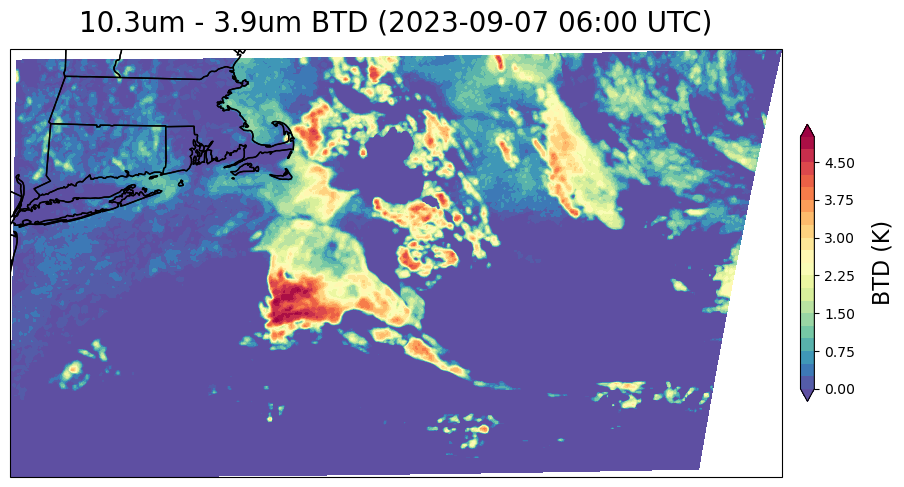

In [13]:
dt = BTD.time.values[0]
date_str = np.datetime_as_string(dt)[:10]
time_str = np.datetime_as_string(dt)[11:16]


projection=ccrs.PlateCarree()
fig,ax=plt.subplots(1, figsize=(12,12),subplot_kw={'projection': projection})
cmap = plt.cm.Spectral_r
levels = np.linspace(0, 5, 21)

c=ax.contourf(BTD.lon, BTD.lat, BTD[0], cmap=cmap, extend='both', levels=levels)
clb=plt.colorbar(c, shrink=0.3, pad=0.02, ax=ax)
ax.set_title('10.3um - 3.9um BTD ('+date_str +' '+time_str+' UTC)', fontsize=20, pad=12)
clb.set_label('BTD (K)', fontsize=16, labelpad=12)

ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.COASTLINE)

plt.savefig("sample_images/b13_b07_"+date_str[0:4]+date_str[5:7]+date_str[8:10]+"_"+time_str[0:2], bbox_inches='tight')

## Making the corrected low cloud field:
* Subtracting the 11.2-10.3 from the 11.2-3.9 BTD
* Theoretically removing the false low clouds
* Needs the above cells to have been run

**Creating the split window difference between two LWIR bands:**

In [14]:
SWD = create_BTD(ds_14, ds_13, filename)

Processing first band for 2023-250 06:00
Processing second band for 2023-250 06:00


**Removing the negative brightness temperature differences:**

In [15]:
SWD = xr.where(SWD < 0, 0, SWD)
NLCT = BTD
NLCT = xr.where(NLCT < 0, 0, NLCT)

**Subtracting the SWD from the NLCT:**

In [16]:
LowCloudField = NLCT - SWD

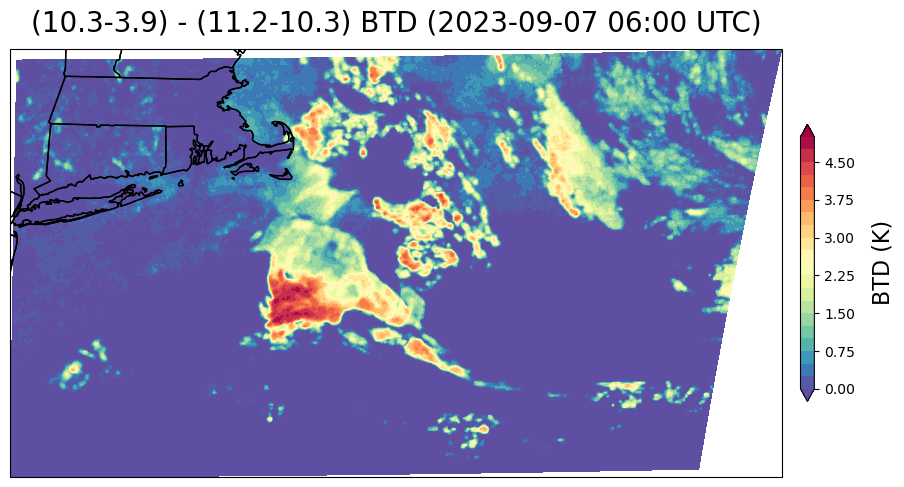

In [17]:
dt = LowCloudField.time.values[0]
date_str = np.datetime_as_string(dt)[:10]
time_str = np.datetime_as_string(dt)[11:16]


projection=ccrs.PlateCarree()
fig,ax=plt.subplots(1, figsize=(12,12),subplot_kw={'projection': projection})
cmap = plt.cm.Spectral_r
levels = np.linspace(0, 5, 21)

c=ax.contourf(LowCloudField.lon, LowCloudField.lat, LowCloudField[0], cmap=cmap, extend='both', levels=levels)
clb=plt.colorbar(c, shrink=0.3, pad=0.02, ax=ax)
ax.set_title('(10.3-3.9) - (11.2-10.3) BTD ('+date_str +' '+time_str+' UTC)', fontsize=20, pad=12)
clb.set_label('BTD (K)', fontsize=16, labelpad=12)

ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.COASTLINE)

#plt.savefig("sample_images/lowcloudfield_"+date_str[0:4]+date_str[5:7]+date_str[8:10]+"_"+time_str[0:2], bbox_inches='tight')

## Subtracting the Model_NLCT from the NLCT:

* this is calculated in ../Model/Model_NLCT.ipynb
* the model estimates the background emission in 11.2-3.9um

In [18]:
model_filename = 'model_btd_georgesbank_20230907 06z.npy'
model_nlct = np.load('../Model/'+model_filename)

How do I translate this coarse model grid to the IR imagery? 

In [19]:
print("shape", np.shape(model_nlct))
print("max", np.nanmax(model_nlct))
print("min", np.nanmin(model_nlct))

shape (24, 40)
max 3.07193
min -2.0346985


In [20]:
print("shape", np.shape(NLCT))
print("max", np.nanmax(NLCT))
print("min", np.nanmin(NLCT))

shape (1, 224, 426)
max 5.0765686
min 0.0


In [21]:
#--- Creating datetime string
year = model_filename[22:26]
month = model_filename[26:28]
day = model_filename[28:30]
hour = model_filename[31:33]

model_dt = year + "-" + month + "-" + day + " " + hour +":00 UTC"
print(model_dt)

2023-09-07 06:00 UTC


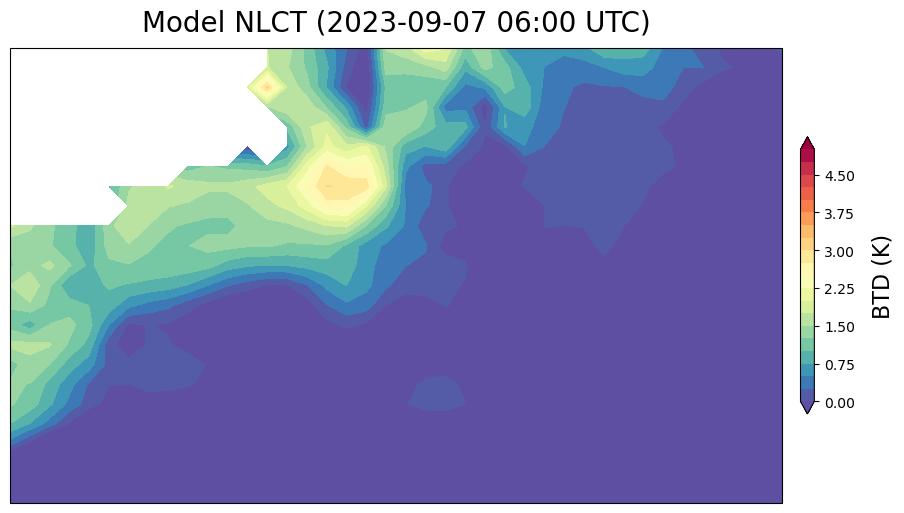

In [22]:
fig,ax=plt.subplots(1, figsize=(12,12),subplot_kw={'projection': projection})
cmap = plt.cm.Spectral_r
levels = np.linspace(0, 5, 21)

c=ax.contourf(range(np.shape(model_nlct)[1]), range(np.shape(model_nlct)[0]), model_nlct, cmap=cmap, 
              extend='both', levels=levels)
clb=plt.colorbar(c, shrink=0.3, pad=0.02, ax=ax)
ax.set_title('Model NLCT ('+model_dt+')', fontsize=20, pad=12)
clb.set_label('BTD (K)', fontsize=16, labelpad=12)

plt.savefig("sample_images/flci_"+date_str[0:4]+date_str[5:7]+date_str[8:10]+"_"+time_str[0:2], bbox_inches='tight')

Reducing the resolution of the satellite data to match the model data: 

In [23]:
import pandas as pd

In [24]:
lcf = pd.DataFrame(LowCloudField[0].values)

In [25]:
lcf.shape

(224, 426)

In [26]:
resampled_x = slice(0, lcf.shape[0], 9)
resampled_y = slice(0, lcf.shape[1], 11)

In [27]:
sat_data_coarse = lcf.iloc[resampled_x, resampled_y]

In [28]:
np.shape(sat_data_coarse)

(25, 39)

In [29]:
crop_sat_data_coarse = sat_data_coarse.iloc[:24]
crop_sat_data_coarse = crop_sat_data_coarse.iloc[::-1] #---satellite data was upside down
crop_model_nlct = model_nlct[:,:39]
print("shape of satellite data:", np.shape(crop_sat_data_coarse))
print("shape of model data:", np.shape(crop_model_nlct))

shape of satellite data: (24, 39)
shape of model data: (24, 39)


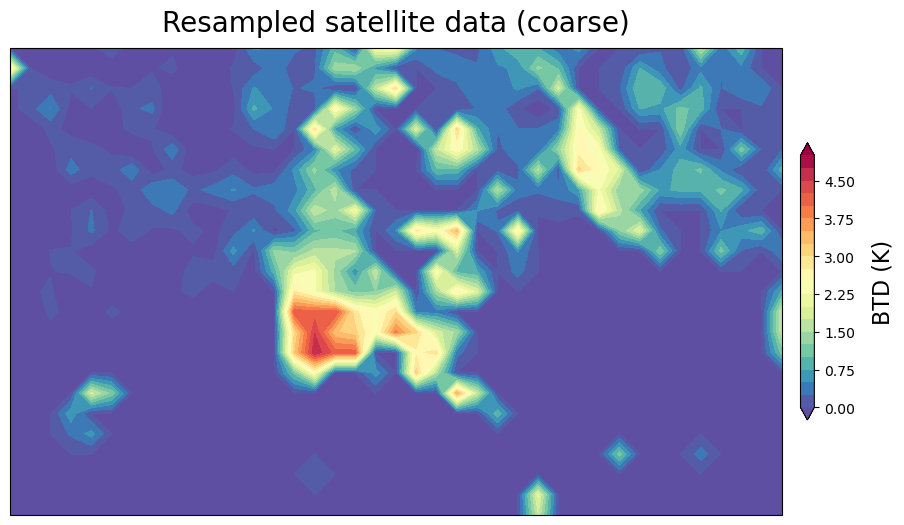

In [30]:
fig,ax=plt.subplots(1, figsize=(12,12),subplot_kw={'projection': projection})
cmap = plt.cm.Spectral_r
levels = np.linspace(0, 5, 21)

c=ax.contourf(range(np.shape(crop_sat_data_coarse)[1]), range(np.shape(crop_sat_data_coarse)[0]), 
              crop_sat_data_coarse, cmap=cmap, extend='both', levels=levels)
clb=plt.colorbar(c, shrink=0.3, pad=0.02, ax=ax)
ax.set_title('Resampled satellite data (coarse)', fontsize=20, pad=12)
clb.set_label('BTD (K)', fontsize=16, labelpad=12)

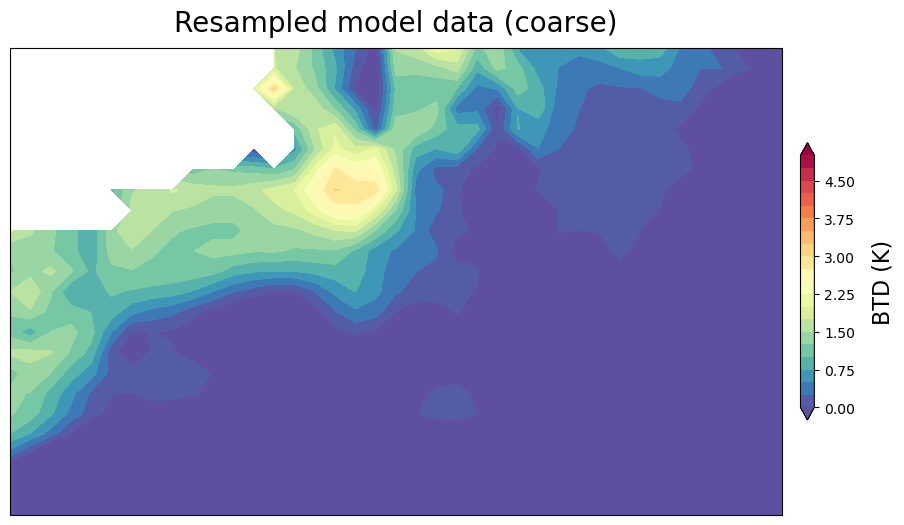

In [31]:
fig,ax=plt.subplots(1, figsize=(12,12),subplot_kw={'projection': projection})
cmap = plt.cm.Spectral_r
levels = np.linspace(0, 5, 21)

c=ax.contourf(range(np.shape(crop_model_nlct)[1]), range(np.shape(crop_model_nlct)[0]), 
              crop_model_nlct, cmap=cmap, extend='both', levels=levels)
clb=plt.colorbar(c, shrink=0.3, pad=0.02, ax=ax)
ax.set_title('Resampled model data (coarse)', fontsize=20, pad=12)
clb.set_label('BTD (K)', fontsize=16, labelpad=12)

In [32]:
#---Remove negative values from both
crop_model_nlct = np.maximum(crop_model_nlct, 0) #--- maximum compares each value to zero and picks the larger of the two
crop_sat_data_coarse = np.maximum(crop_sat_data_coarse, 0)

In [33]:
corrected_cloud_field = crop_sat_data_coarse-crop_model_nlct

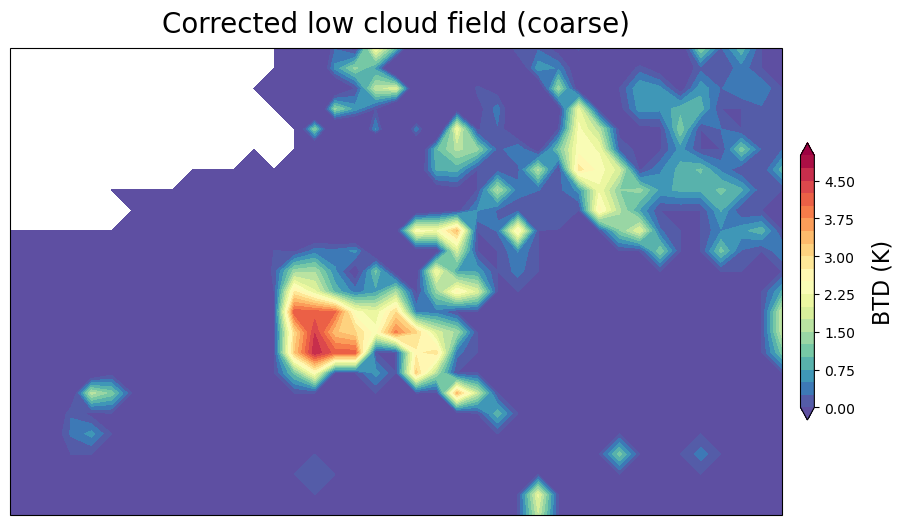

In [34]:
fig,ax=plt.subplots(1, figsize=(12,12),subplot_kw={'projection': projection})
cmap = plt.cm.Spectral_r
levels = np.linspace(0, 5, 21)

c=ax.contourf(range(np.shape(corrected_cloud_field)[1]), range(np.shape(corrected_cloud_field)[0]), corrected_cloud_field, cmap=cmap, extend='both', levels=levels)
clb=plt.colorbar(c, shrink=0.3, pad=0.02, ax=ax)
ax.set_title('Corrected low cloud field (coarse)', fontsize=20, pad=12)
clb.set_label('BTD (K)', fontsize=16, labelpad=12)

plt.savefig("sample_images/flci_lowcloudfield_"+date_str[0:4]+date_str[5:7]+date_str[8:10]+"_"+time_str[0:2], bbox_inches='tight')

In [35]:
highlight_flc = crop_sat_data_coarse*crop_model_nlct

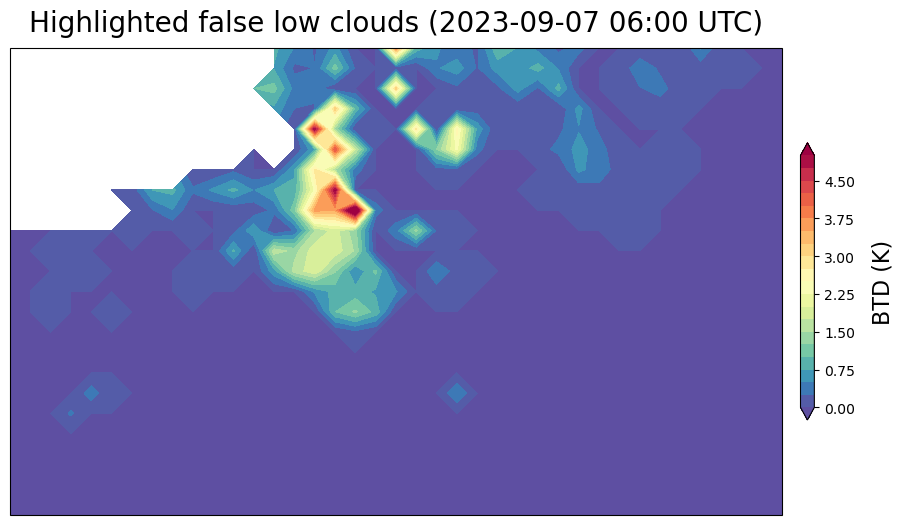

In [36]:
fig,ax=plt.subplots(1, figsize=(12,12),subplot_kw={'projection': projection})
cmap = plt.cm.Spectral_r
levels = np.linspace(0, 5, 21)

c=ax.contourf(range(np.shape(highlight_flc)[1]), range(np.shape(highlight_flc)[0]), highlight_flc, cmap=cmap, extend='both', levels=levels)
clb=plt.colorbar(c, shrink=0.3, pad=0.02, ax=ax)
ax.set_title('Highlighted false low clouds ('+model_dt+')', fontsize=20, pad=12)
clb.set_label('BTD (K)', fontsize=16, labelpad=12)

plt.savefig("sample_images/flci_highlight_"+date_str[0:4]+date_str[5:7]+date_str[8:10]+"_"+time_str[0:2], bbox_inches='tight')

## Interpolating the model data to increase resolution
* I think the problem here is that the LowCloudField x and y are not on a regular grid
* I believe I need a different function to interpolate the model data to a non-regular grid
* scipy LinearNDInterpolator, NearestNDInterpolator, etc

In [37]:
lcf.shape

(224, 426)

In [38]:
model_nlct.shape

(24, 40)

In [39]:
x_zoom = lcf.shape[0]/model_nlct.shape[0]
y_zoom = lcf.shape[1]/model_nlct.shape[1]

In [40]:
#model_nlct_nonan = np.nan_to_num(model_nlct)

In [41]:
#--- 0 is nearest, 1 is bilinear, 3 is cubic
order = 1 

enhance = scipy.ndimage.zoom(model_nlct, zoom=[x_zoom,y_zoom], order=order, mode='constant')

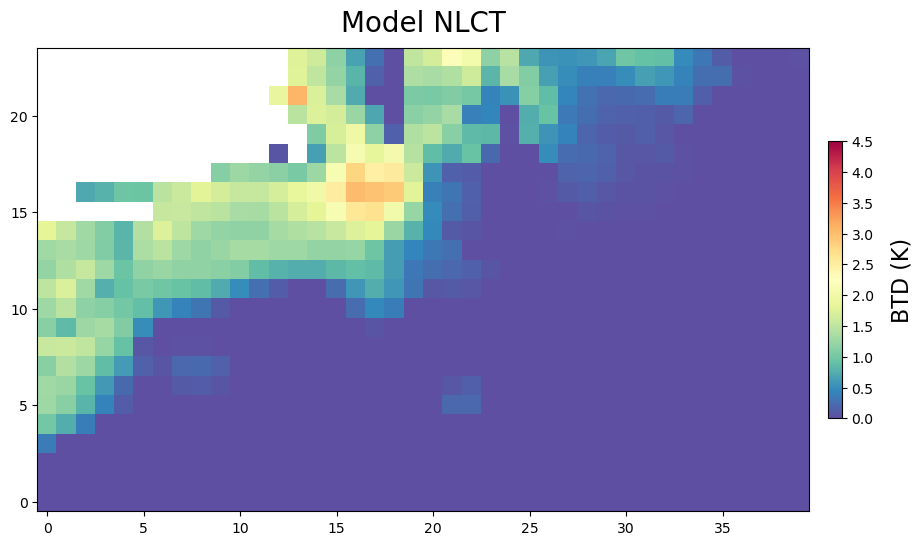

In [42]:
fig,ax=plt.subplots(1, figsize=(12,12))
cmap = plt.cm.Spectral_r

img=ax.imshow(model_nlct, cmap='Spectral_r', origin='lower', vmin=0, vmax=4.5)
clb=plt.colorbar(img, shrink=0.3, pad=0.02, ax=ax)
ax.set_title('Model NLCT', fontsize=20, pad=12)
clb.set_label('BTD (K)', fontsize=16, labelpad=12)

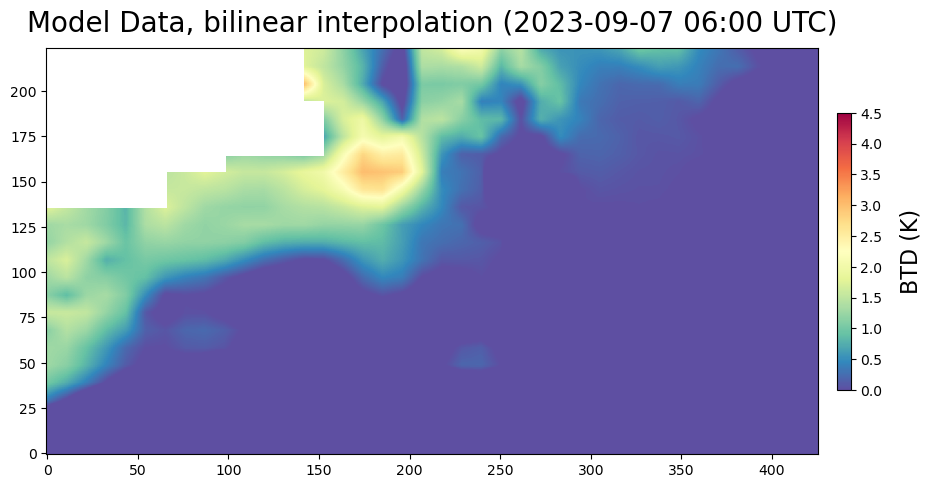

In [43]:
fig,ax=plt.subplots(1, figsize=(12,12))
cmap = plt.cm.Spectral_r

img=ax.imshow(enhance, cmap='Spectral_r', origin='lower', vmin=0, vmax=4.5)
clb=plt.colorbar(img, shrink=0.3, pad=0.02, ax=ax)
if order == 1:
    type = 'bilinear'
if order == 0: 
    type = 'nearest'
if order == 3:
    type = 'cubic'
ax.set_title('Model Data, '+type+' interpolation ('+model_dt+')', fontsize=20, pad=12)
clb.set_label('BTD (K)', fontsize=16, labelpad=12)
plt.savefig("sample_images/model_interpolation_"+date_str[0:4]+date_str[5:7]+date_str[8:10]+"_"+time_str[0:2], bbox_inches='tight')

In [44]:
#--- flipping satellite image right side up

sat_lcf = np.flipud(LowCloudField[0].values)

#--- removing the negative values

sat_lcf = np.maximum(sat_lcf, 0) #--- maximum compares each value to zero and picks the larger of the two
enhance = np.maximum(enhance, 0)

In [45]:
highlight_flc = sat_lcf*enhance

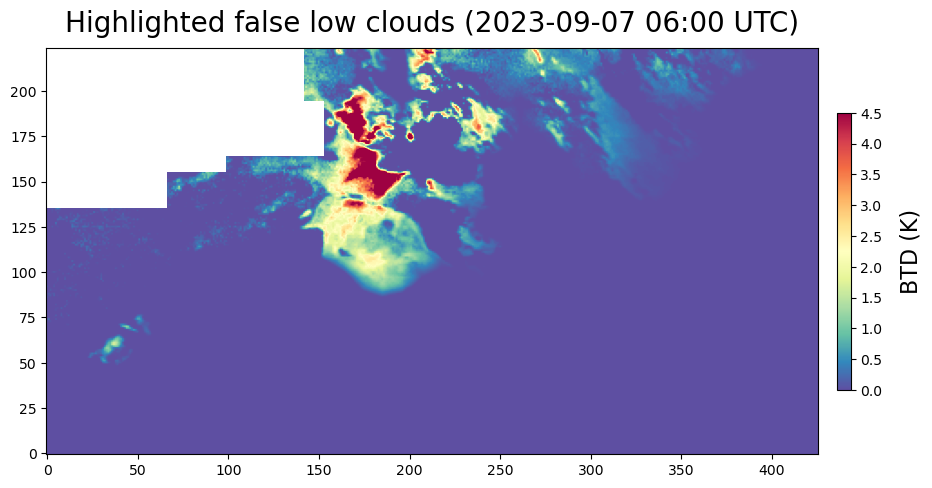

In [46]:
fig,ax=plt.subplots(1, figsize=(12,12))

img=ax.imshow(highlight_flc, cmap='Spectral_r', origin='lower', vmin=0, vmax=4.5)
clb=plt.colorbar(img, shrink=0.3, pad=0.02, ax=ax)
ax.set_title('Highlighted false low clouds ('+model_dt+')', fontsize=20, pad=12)
clb.set_label('BTD (K)', fontsize=16, labelpad=12)

plt.savefig("sample_images/flci_highlight_"+date_str[0:4]+date_str[5:7]+date_str[8:10]+"_"+time_str[0:2], bbox_inches='tight')

In [47]:
corrected_cloud_field = sat_lcf-enhance

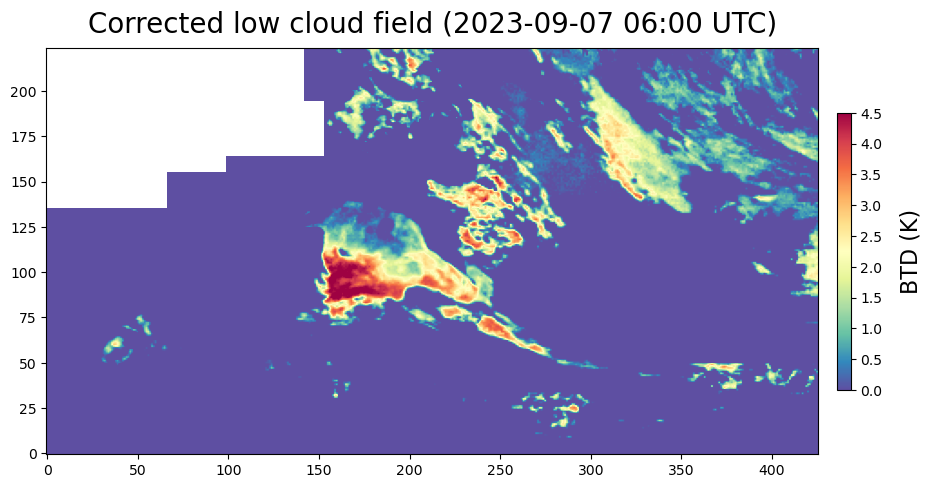

In [48]:
fig,ax=plt.subplots(1, figsize=(12,12))

img=ax.imshow(corrected_cloud_field, cmap='Spectral_r', origin='lower', vmin=0, vmax=4.5)
clb=plt.colorbar(img, shrink=0.3, pad=0.02, ax=ax)
ax.set_title('Corrected low cloud field ('+model_dt+')', fontsize=20, pad=12)
clb.set_label('BTD (K)', fontsize=16, labelpad=12)

plt.savefig("sample_images/flci_lowcloudfield_"+date_str[0:4]+date_str[5:7]+date_str[8:10]+"_"+time_str[0:2], bbox_inches='tight')

## Enhancement Animation

In [49]:
def create_frame(model_nlct, x_zoom, y_zoom, order):

    enhance = scipy.ndimage.zoom(model_nlct, zoom=[x_zoom, y_zoom], order=order, mode='constant')

    fig,ax=plt.subplots(1, figsize=(12,12))
    cmap = plt.cm.Spectral_r
    
    img=ax.imshow(enhance, cmap='Spectral_r', origin='lower', vmin=0, vmax=4.5)
    clb=plt.colorbar(img, shrink=0.3, pad=0.02, ax=ax)
    if order == 1:
        type = 'bilinear'
    if order == 0: 
        type = 'nearest'
    if order == 3:
        type = 'cubic'
    ax.set_title('Model Data, '+type+' interpolation ('+str(x_zoom)+'x, '+str(y_zoom)+'x)', fontsize=20, pad=12)
    clb.set_label('BTD (K)', fontsize=16, labelpad=12)
    
    # Save the current figure to a BytesIO buffer
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)

    # Read the BytesIO buffer and return as an image
    frame = imageio.v2.imread(buf)

    # Clear the current figure to avoid overlapping plots
    plt.clf()

    return frame

In [50]:
zooms = np.arange(1,10)

frames = []
for zoom in zooms:
    frame = create_frame(model_nlct, zoom, zoom, 1)
    frames.append(frame)

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

In [51]:
imageio.mimsave('sample_images/enhancing_model_bilinear.gif', frames, loop=0, duration=1000, bbox_inches='tight')